<h1 align="center"> Machine Learning </h1>
<h2 align="center"> Coding Assignemt 2</h3>
<h5 align="center"> <font color="cyan"> Mohammad Hossein Shafieizadegan </font> </h5>
<h5 align="center"> <font color="cyan"> 99104781 </font></h5>

# Introduction to artificial neural networks

__Introduction:__ Artificial neural networks have a similar architechture to perceptron networks. The main difference is that the activation functions will differentiable (maybe except a few points, where they have subgradients), and by differentiating an appropriate loss function with respect to the pararmeters, we train the model. The differentiation process is done automatically in the AutoGrad part of PyTorch. <br>
In the following questions, you will build and train multiple neural networks on MNIST and CIFAR10 datasets

## Part 1: Fully connected networks and activation functions

We want to investigate the effect of activation functions in neural network learning process. So, implement neural networks with identical linear layers, identical batch sizes and identical optimizers, but use different activation functions between the linear layers. <br>
Train and your network on the following activation functions. Plot training losses of each epoch for every model on a single graph, and compare the results, specifically in terms of convergence speeds. Also, Compare the train set and test set accuracies for each function. <br>
1: Sigmoid <br>
2: ReLU <br>
3: Leaky ReLU <br>

For your convenience, we break the procedure into multiple steps: <br>
1: Load the MNIST dataset and show an image from each class <br>
2: Define Dataloaders for the train and test sets. <br>
3: Define your network, with multiple (four or five) fully-connected layers and nonlinear activations in between. The network output size must match the number of classes, as the outputs are treated as logits for a softmax function and NLL loss. <br>
4: Use a CrossEntropyLoss function (Pytorch function), and a suitable optimizer (from torch.optim). <br>
5: Train the network (__Hint:__ Use what you have learned in CHW0, for instance zeroing the gradients and utilizing a GPU). Print the loss function after each epoch. You should divide the value by your batch size, so that the values are comparable for different batch sizes.<br>
6: Report you train and test set losses and accuracies. <br>
__Hint 2__: Use the documentations of the imported libraries and submodules. For instance, you can find all neural network layers in torch.nn submodule.

### Import Libraries <br>
These are some libraries that you may need for this part. You are free to change this block

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

### Neural network template
The following block is a template to define your network. Note that we inherit from nn.Module, so we need to implement the forward and init (constructor in Python) functions.

In [2]:
class FC_Neural_network(nn.Module):
    def __init__(self):

        super(FC_Neural_network, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x, act_func):

        x = torch.flatten(x, 1)
        x = self.fc1(x)

        if act_func == "sigmoid":
            x = torch.sigmoid(x)
        elif act_func == "relu":
            x = torch.relu(x)
        elif act_func == "Leaky relu":
            x = nn.functional.leaky_relu(x, negative_slope=0.01)

        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x



### Accuracy calculation template <br>
Calculate your train and set accuracies with this template. <br>
__Question:__ Why is torch.no_grad used here?

__Answer:__ <br>
<font color="cyan">
    The `torch.no_grad()` context manager is used here to optimize memory and computational efficiency during the evaluation phase of a neural network. It indicates that gradient calculations and storage are not needed because we are not training the network at this stage. By disabling gradient computation, we can save resources and make the evaluation process faster. This context manager ensures that no gradients are computed or stored during the evaluation, allowing for efficient execution of the code.
</font>

In [3]:
# Accuracy calculation template
def calculate_accuracy(network, data_loader, device, act_func, criterion):
    network.eval()
    correct = 0
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = network(inputs, act_func)
            total_loss += criterion(outputs, labels).item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        loss = total_loss / len(data_loader.dataset)
        accuracy = correct / len(data_loader.dataset) * 100
        return loss, accuracy

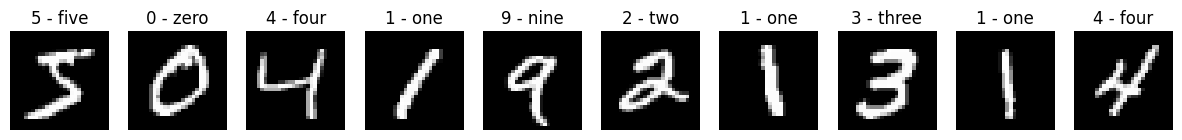

In [4]:
# Step 1: Load the MNIST dataset and show an image from each class
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Show an image from each class
classes = train_dataset.classes
figure, axes = plt.subplots(1, len(classes), figsize=(15, 15))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().numpy(), cmap='gray')
    ax.set_title(classes[label])
    ax.axis('off')
plt.show()

In [5]:
# Step 2: Define Dataloaders for the train and test sets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [7]:
# Step 5: Train the network
def train(network, train_loader, test_loader, optimizer, criterion, device, act_func, num_epochs = 5):

    network.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = network(inputs, act_func)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], "
                      f"Batch [{batch_idx + 1}/{len(train_loader)}], "
                      f"Loss: {running_loss / (batch_idx + 1):.4f}, "
                      f"Accuracy: {100.0 * correct / total:.2f}%")

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Training Loss: {epoch_loss:.4f}, "
              f"Training Accuracy: {100.0 * correct / total:.2f}%")

        test_loss, test_accuracy = calculate_accuracy(network, test_loader, device, act_func, criterion)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")
        print("------------------------------------------------------------------")


activation_functions = ["sigmoid", "relu", "Leaky relu"]

for act_func in activation_functions:

    print(f"*** NN with {act_func} activation function:  ***")
    network = FC_Neural_network().to(device)
    optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    train(network, train_loader, test_loader, optimizer, criterion, device, act_func)


*** NN with sigmoid activation function:  ***
Epoch [1/5], Batch [100/938], Loss: 2.2127, Accuracy: 23.45%
Epoch [1/5], Batch [200/938], Loss: 1.6970, Accuracy: 43.77%
Epoch [1/5], Batch [300/938], Loss: 1.3301, Accuracy: 56.36%
Epoch [1/5], Batch [400/938], Loss: 1.1242, Accuracy: 63.47%
Epoch [1/5], Batch [500/938], Loss: 0.9906, Accuracy: 68.13%
Epoch [1/5], Batch [600/938], Loss: 0.8936, Accuracy: 71.42%
Epoch [1/5], Batch [700/938], Loss: 0.8220, Accuracy: 73.84%
Epoch [1/5], Batch [800/938], Loss: 0.7667, Accuracy: 75.70%
Epoch [1/5], Batch [900/938], Loss: 0.7227, Accuracy: 77.19%
Epoch [1/5], Training Loss: 0.7073, Training Accuracy: 77.70%
Epoch [1/5] - Test Loss: 0.3253 - Test Acc: 90.78%
------------------------------------------------------------------
Epoch [2/5], Batch [100/938], Loss: 0.3445, Accuracy: 89.92%
Epoch [2/5], Batch [200/938], Loss: 0.3234, Accuracy: 90.48%
Epoch [2/5], Batch [300/938], Loss: 0.3145, Accuracy: 90.80%
Epoch [2/5], Batch [400/938], Loss: 0.3124

## Part 1-2: Limitations of fully connected neural networks

In practice, a combination of convolutional and fully connected layers are preferred to networks having only fully connected networks. To better understand the reason, train another fully connected network, this time on the CIFAR10 dataset, and report your results. Use at least 20 epochs of training, and if it takes long to train the network, increase the batch size in your dataloaders. After that, train your existing model for 10 more epochs and report the validation set accuracy again. Or you can calculate the validation set accuraccy after each epoch.

In [8]:
class FC_Neural_network_2(nn.Module):
    def __init__(self):

        super(FC_Neural_network_2, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x, act_func):

        x = torch.flatten(x, 1)
        x = self.fc1(x)

        if act_func == "sigmoid":
            x = torch.sigmoid(x)
        elif act_func == "relu":
            x = torch.relu(x)
        elif act_func == "Leaky relu":
            x = nn.functional.leaky_relu(x, negative_slope=0.01)

        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x



In [9]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# Load CIFAR-10 dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valset = CIFAR10(root='./data', train=False, download=True, transform=transform_val)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Step 4: Use a CrossEntropyLoss function and a suitable optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

network = FC_Neural_network_2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.9)


Device: cuda


In [12]:
train(network, train_loader, val_loader, optimizer, criterion, device, "relu", num_epochs=20)


Epoch [1/20], Batch [100/782], Loss: 2.1365, Accuracy: 20.86%
Epoch [1/20], Batch [200/782], Loss: 2.0512, Accuracy: 24.44%
Epoch [1/20], Batch [300/782], Loss: 1.9937, Accuracy: 26.69%
Epoch [1/20], Batch [400/782], Loss: 1.9485, Accuracy: 28.55%
Epoch [1/20], Batch [500/782], Loss: 1.9179, Accuracy: 29.70%
Epoch [1/20], Batch [600/782], Loss: 1.8955, Accuracy: 30.66%
Epoch [1/20], Batch [700/782], Loss: 1.8740, Accuracy: 31.63%
Epoch [1/20], Training Loss: 1.8600, Training Accuracy: 32.16%
Epoch [1/20] - Test Loss: 1.6780 - Test Acc: 39.98%
------------------------------------------------------------------
Epoch [2/20], Batch [100/782], Loss: 1.7231, Accuracy: 37.50%
Epoch [2/20], Batch [200/782], Loss: 1.7164, Accuracy: 38.16%
Epoch [2/20], Batch [300/782], Loss: 1.7177, Accuracy: 37.93%
Epoch [2/20], Batch [400/782], Loss: 1.7091, Accuracy: 38.34%
Epoch [2/20], Batch [500/782], Loss: 1.7045, Accuracy: 38.48%
Epoch [2/20], Batch [600/782], Loss: 1.6979, Accuracy: 38.77%
Epoch [2/20]

In [13]:
train(network, train_loader, val_loader, optimizer, criterion, device, "relu", num_epochs=10)

Epoch [1/10], Batch [100/782], Loss: 1.4348, Accuracy: 48.39%
Epoch [1/10], Batch [200/782], Loss: 1.4212, Accuracy: 48.95%
Epoch [1/10], Batch [300/782], Loss: 1.4171, Accuracy: 49.24%
Epoch [1/10], Batch [400/782], Loss: 1.4175, Accuracy: 49.28%
Epoch [1/10], Batch [500/782], Loss: 1.4121, Accuracy: 49.42%
Epoch [1/10], Batch [600/782], Loss: 1.4133, Accuracy: 49.45%
Epoch [1/10], Batch [700/782], Loss: 1.4126, Accuracy: 49.35%
Epoch [1/10], Training Loss: 1.4135, Training Accuracy: 49.34%
Epoch [1/10] - Test Loss: 1.4469 - Test Acc: 49.91%
------------------------------------------------------------------
Epoch [2/10], Batch [100/782], Loss: 1.4032, Accuracy: 50.23%
Epoch [2/10], Batch [200/782], Loss: 1.4093, Accuracy: 49.65%
Epoch [2/10], Batch [300/782], Loss: 1.4106, Accuracy: 49.68%
Epoch [2/10], Batch [400/782], Loss: 1.4056, Accuracy: 49.77%
Epoch [2/10], Batch [500/782], Loss: 1.4059, Accuracy: 49.72%
Epoch [2/10], Batch [600/782], Loss: 1.4068, Accuracy: 49.85%
Epoch [2/10]

## Part 2: Transfer learning for image classification

In this part, we use pretrained models available in PyTorch, and fine-tune them for our desire purposes. In many cases, models that were trained on different datasets from our own, can still be used effectively for our tasks, which will save us valuable training time and resources. In this case, we aim to use AlexNet, trained on ImageNet ,for a classification task an CIFAR10.<br>
1: Load AlexNet with predefined weights using PyTorch. <br>
2: Load the CIFAR10 dataset, and plot an image of each class. <br>
3: Resize it to $224 \times 224$, the input size of AlexNet. Only use the first few (two, three, or any number of your choice) classes, to reduce the computational load.<br>
4: Change the fully connected layers, suitable for a classification task on the CIFAR10 dataset. Remember to reset the weights of the fully-connected layers, but not the convolutional layers. In this example, the convolutional layers are regarded as feature extractors and the fully-connected layers as the classifier network. <br>
5: Answer the following question: What are .train() and .eval() functions for a model, and why, in this particular example, are important to use? Name any layer/layers in AlexNet that effected by these functions.
6: Define a suitable loss function, train the model, report the training loss and accuracy after each epoch, and calculate them as well for the test set, after the training has been completed. The convolutional layers must be frozen before the training starts. <br>

In [14]:
from torchvision.models import alexnet
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10


In [15]:
# Step 1: Load pre-trained AlexNet with predefined weights
model = alexnet(pretrained=True)

# Step 2: Load CIFAR10 dataset and plot an image of each class
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified


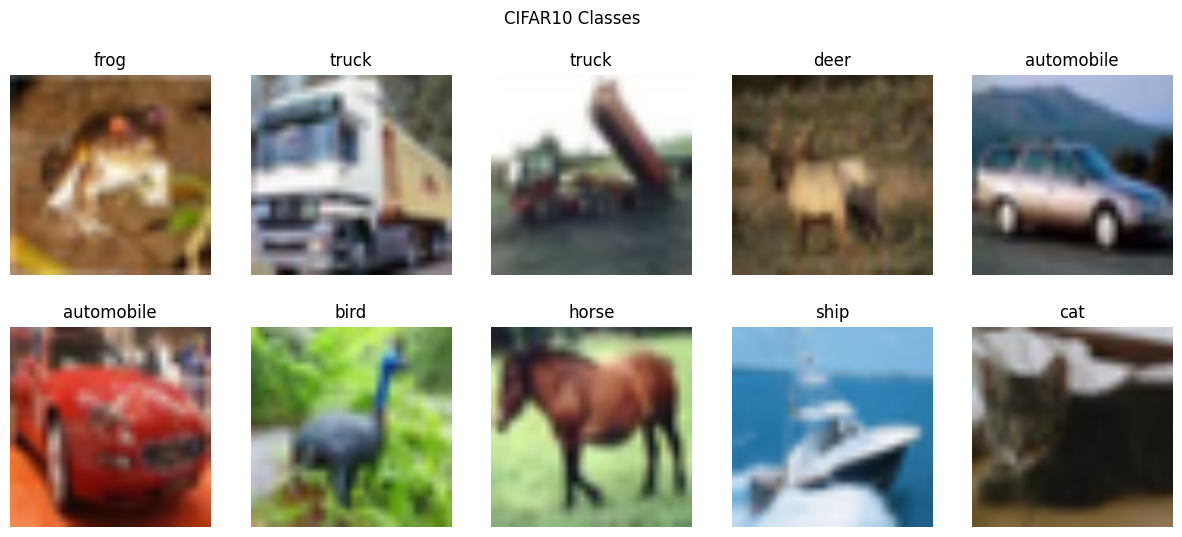

In [16]:
import matplotlib.pyplot as plt
import numpy as np

classes = trainset.classes
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('CIFAR10 Classes')
for i, ax in enumerate(axs.flat):
    img, label = trainset[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(classes[label])
    ax.axis('off')

plt.show()

In [17]:
# Use only two, to reduce the computational load
# Define the classes you want to use
class_labels = [0, 4]  # Replace with the indices of the classes you want to use

# Filter the dataset to include only the specified classes
train_indices = [i for i in range(len(trainset)) if trainset.targets[i] in class_labels]
test_indices = [i for i in range(len(testset)) if testset.targets[i] in class_labels]

# Create custom datasets with only the selected classes
filtered_train_dataset = torch.utils.data.Subset(trainset, train_indices)
filtered_test_dataset = torch.utils.data.Subset(testset, test_indices)


In [18]:
# Step 4: Change fully connected layers for the classification task
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)


In [19]:
# Reset the weights of the fully-connected layers, but not the convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

__5: Answer to the questiosn__ <br>

<font color="cyan">

- The ``.train()`` function sets the model in training mode, enabling gradient computation and updating of trainable parameters.
- The ``.eval()`` function sets the model in evaluation mode, disabling gradient computation and freezing the parameters. <br><br>

In this example, it is important to use `.eval()` during evaluation to ensure that the model behaves consistently
and does not update its parameters based on the evaluation data.

Layers affected by `.train()` and `.eval()` functions in AlexNet:
 - **Dropout layers:** Affected by `.train()` to apply dropout regularization during training.
 - **Batch Normalization layers:** Affected by `.train()` to track running statistics and apply normalization during training.

 </font>

In [20]:
# Step 6: Define loss function, train the model, and report metrics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

train_loader = torch.utils.data.DataLoader(filtered_train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(filtered_test_dataset, batch_size=32, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    class_label_mapping = {0: 0, 4: 1}

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = torch.tensor([class_label_mapping[label.item()] for label in labels], device=device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], "
                      f"Batch [{batch_idx + 1}/{len(train_loader)}], "
                      f"Loss: {train_loss / (batch_idx + 1):.4f}, "
                      f"Accuracy: {100.0 * correct / total:.2f}%")

    train_accuracy = 100 * correct / total
    train_loss /= len(train_loader)

    # Evaluation on test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = torch.tensor([class_label_mapping[label.item()] for label in labels], device=device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct / total
    test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - "
          f"Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")

Device: cuda
Epoch [1/5], Batch [100/313], Loss: 0.2549, Accuracy: 89.19%
Epoch [1/5], Batch [200/313], Loss: 0.2208, Accuracy: 90.78%
Epoch [1/5], Batch [300/313], Loss: 0.2159, Accuracy: 91.09%
Epoch 1/5 - Train Loss: 0.2134 - Train Acc: 91.22% - Test Loss: 0.1152 - Test Acc: 95.85%
Epoch [2/5], Batch [100/313], Loss: 0.1487, Accuracy: 94.19%
Epoch [2/5], Batch [200/313], Loss: 0.1601, Accuracy: 93.69%
Epoch [2/5], Batch [300/313], Loss: 0.1545, Accuracy: 93.84%
Epoch 2/5 - Train Loss: 0.1545 - Train Acc: 93.91% - Test Loss: 0.0932 - Test Acc: 96.35%
Epoch [3/5], Batch [100/313], Loss: 0.1555, Accuracy: 93.75%
Epoch [3/5], Batch [200/313], Loss: 0.1486, Accuracy: 93.91%
Epoch [3/5], Batch [300/313], Loss: 0.1423, Accuracy: 94.20%
Epoch 3/5 - Train Loss: 0.1426 - Train Acc: 94.25% - Test Loss: 0.0923 - Test Acc: 96.35%
Epoch [4/5], Batch [100/313], Loss: 0.1305, Accuracy: 94.81%
Epoch [4/5], Batch [200/313], Loss: 0.1327, Accuracy: 94.69%
Epoch [4/5], Batch [300/313], Loss: 0.1327, Ac